> In this notebook, we explored different ways to carry out the Topic Modelling to generate topics with topic keywords. The following modules were explored:<ul>
    <li>Scikit-Learn LDA (<a href='#sklearn-lda'>Click to view</a>)</li>
    <li>Scikit-Learn NMF (<a href='#sklearn-nmf'>Click to view</a>)</li>
    <li>Gensim LDA (<a href='#gensim-lda'>Click to view</a>)</li>
    <li>LDA Mallet (<a href='#lda-mallet'>Click to view</a>)</li></ul>
  We chose LDA Mallet in the end, for its built-in optimization of parameters, faster computation and better performance with respect to coherence score. <br>
  We then tuned the hyperparameter, the topic numbers, of 30.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
transcript_tokens = pickle.load(open('data/pickle/transcript_tokens.p','rb'))

In [3]:
# default parameter for baseline comparison
n_topics = 50
top_n_words = 10

<a id='sklearn-lda'></a>
<h2>Scikit-Learn LDA with tf-idf vectorizer</h2>


> From the results shown below, we can see that the topics generated are not very distinctive. It is hard to identify the concept/topic from the list of topic words. Therefore, we discarded this method. 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from functions.tfidf_vectorizer_functions import * # the string seperator is fixed with "{@}"

In [5]:
# Load the tf-idf vectorizer from the TF-IDF Metric Computation notebook
vectorizer = pickle.load(open('model/tfidf_vectorizer.p','rb'))

In [6]:
string_seperator = "{@}"

transcript_tokens_str = [string_seperator.join(tokens) for tokens in transcript_tokens]

vectors = vectorizer.transform(transcript_tokens_str)

In [12]:
lda = LatentDirichletAllocation(n_components=n_topics,random_state=2020)

topics = lda.fit_transform(vectors)

t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    
sklearn_lda_df = pd.DataFrame(t_words).transpose()
sklearn_lda_df.columns = ["keyword {}".format(str(i)) for i in sklearn_lda_df.columns]

In [21]:
sklearn_lda_df.head(10)

,keyword 0,keyword 1,keyword 2,keyword 3,keyword 4,keyword 5,keyword 6,keyword 7,keyword 8,keyword 9
0,people,like,go,think,know,thing,time,look,want,say
1,hard choice,catadore,jihad,fibonacci,carroça,fibonacci number,squared,suspend animation,Spinosaurus,violin
2,comet,Kepler,Rezero,Zimbabwe,morning come,multipotentialite,lap,nonviolent struggle,Flint,prime number
3,jihad,flag,MK,fishery,Gabby,self drive,high sea,strand,self drive car,tk
4,manuscript,sneaker,vulture,genocide,cmu,Panbanisha,exoplanet,sc,amyloid beta,McGowan
5,dinosaur,chromosome,dolphin,astronaut,fossil,suicide,greenhouse,methane,rice,devil
6,mt,Oklahoma City,amino acid,amino,Kanner,Broadmoor,exploitation,rhythm,melody,psychic paper
7,hum,gk,car seat,ak,puppet,aged,ss,middle aged,whistleblower,virtual reality
8,mockingbird,Bonica,mustache,bionic,cousin,listening,humanae,leopard seal,fly camera,Harriet
9,candidate,north,musical,story tell,live life,sphere,beer,diagnosis,regime,breast cancer


<a id='sklearn-nmf'></a>
## Scikit-Learn NMF with tf-idf vectorizer## 

> Non-negative Matrix Factorization is a technique for obtaining low rank representation of matrices with non-negative or positive elements. It is commonly used in many applications, such as computer vision and text mining. <br><br>
From the results, we can easily identify the topics from the topic words, such as the 2nd row is about Ants, 3rd row is about healthcare, followed by business, astronomy and robotics. <br><br>However, based on our research, there is no way to evaluate the performance of the results as it is a vector-space approach instead a probabilistic approach, the Coherence scoring cannot be applied. As such, there is no way for us to tune the hyperparameter, the number of topics, with a standard systematic way of evaluation. 

In [13]:
from sklearn.decomposition import NMF

In [15]:
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(vectors)

t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
sklearn_nmf_df = pd.DataFrame(t_words).transpose()
sklearn_nmf_df.columns = ["keyword {}".format(str(i)) for i in sklearn_nmf_df.columns]

In [22]:
sklearn_nmf_df.head(10)

,keyword 0,keyword 1,keyword 2,keyword 3,keyword 4,keyword 5,keyword 6,keyword 7,keyword 8,keyword 9
0,know,go,say,thing,think,like,get,people,want,come
1,ant,colony,nest,forager,forage,nest maintenance,worker,interaction,maintenance worker,nest maintenance worker
2,patient,health,doctor,care,medical,hospital,surgery,health care,physician,healthcare
3,company,business,money,market,people,work,pay,product,economy,value
4,planet,star,atmosphere,solar,solar system,telescope,life,orbit,light,sun
5,robot,robotic,like,robot like,locomotion,build,leg,look,robot robot,romo
6,brain,neuron,memory,cortex,human brain,disorder,body,consciousness,region,control
7,universe,galaxy,black hole,particle,hole,black,Higgs,star,theory,space
8,city,people,street,neighborhood,urban,map,space,mayor,community,build
9,kid,school,go,parent,teach,say,lunch,child,teacher,know


<a id='gensim-lda'></a>
## Gensim LDA## 

> The baseline performance of LDA is rather good compared to that of Sklearn LDA but not as good as the Sklearn NMF. <br><br>
    We <a href='#gensim-lda-tuning'>tuned the three hyperparameters: alpha, eta and number of topics. </a> <ul>
        <li>Alpha: [0.01, 0.31, 0.61, 0.91, "symmetric" and "asymmetric"]</li><li>Eta: [0.01, 0.31, 0.61, 0.91, "symmetric"]</li><li>Number of topics: 20 to 80.</li></ul> Given the limited computation power and time we had, when we tuned the number of topics with all values for alpha and eta, we took a step of 10 first to narrow down the range followed by a step of 1. The tuning codes in the notebook was the one with the step of 10. The tuning results are not shown as there were a lot of trials to find the best sets of parameters.<br><br>
    The final set of hyperparameters are: <br> <table>
    <tr><th>Parameter</th><th>Value</th></tr>
    <tr><td>Topic number</td><td>58</td></tr>
    <tr><td>Alpha</td><td>asymmetric</td></tr>
    <tr><td>Eta</td><td>symmetric</td></tr>

In [33]:
np.arange(0.01, 1, 0.3)

array([0.01, 0.31, 0.61, 0.91])

In [3]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

D:\Software\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Baseline Performance ###

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(transcript_tokens)

# Create Corpus
texts = transcript_tokens

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [26]:
#alpha suggested value: 50/Topic_num
alpha = 50/n_topics

#eta suggestd value: 200/Voca_num
eta = 200/len(id2word)

print(alpha, eta)

1.0 0.0037225924133566617


In [28]:
# baseline model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics,alpha=alpha, eta=eta,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

D:\Software\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [29]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=transcript_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3488433696280511


In [30]:
# Print the Keyword in the 10 topics
gensim_lda_df = pd.DataFrame()
for idx, topic_string in lda_model.print_topics():
    string_parts = [x.strip().split("*") for x in topic_string.split("+")]
    string_parts = [(x[0],x[1][1:-1]) for x in string_parts]
    gensim_lda_df['topic {}'.format(idx+1)] = string_parts
# doc_lda = list(lda_model[corpus])

In [32]:
gensim_lda_df.transpose().head(10)

,0,1,2,3,4,5,6,7,8,9
topic 41,"(0.092, love)","(0.031, fish)","(0.017, think)","(0.016, come)","(0.012, partner)","(0.011, look)","(0.011, shark)","(0.011, island)","(0.011, know)","(0.011, go)"
topic 5,"(0.049, woman)","(0.028, man)","(0.026, girl)","(0.010, walk)","(0.010, water)","(0.009, come)","(0.009, boy)","(0.009, know)","(0.008, female)","(0.008, go)"
topic 22,"(0.030, actually)","(0.027, time)","(0.023, like)","(0.019, art)","(0.017, thing)","(0.017, space)","(0.015, fly)","(0.015, go)","(0.015, house)","(0.015, library)"
topic 20,"(0.070, heart)","(0.032, save)","(0.030, wish)","(0.029, road)","(0.029, attack)","(0.027, people)","(0.023, go)","(0.022, idea)","(0.022, life)","(0.016, way)"
topic 30,"(0.009, universe)","(0.009, science)","(0.008, like)","(0.006, look)","(0.006, know)","(0.006, space)","(0.005, time)","(0.005, light)","(0.005, thing)","(0.005, think)"
topic 11,"(0.081, want)","(0.044, go)","(0.037, say)","(0.028, come)","(0.028, thing)","(0.027, time)","(0.024, life)","(0.021, talk)","(0.020, like)","(0.020, get)"
topic 19,"(0.034, people)","(0.023, think)","(0.020, go)","(0.019, net)","(0.019, know)","(0.017, talk)","(0.017, get)","(0.017, bed)","(0.016, thing)","(0.015, drug)"
topic 40,"(0.062, life)","(0.037, story)","(0.035, experience)","(0.032, self)","(0.032, people)","(0.029, happy)","(0.021, think)","(0.016, feel)","(0.015, good)","(0.014, happiness)"
topic 35,"(0.097, word)","(0.067, language)","(0.031, write)","(0.028, speak)","(0.020, example)","(0.019, think)","(0.015, sentence)","(0.015, learn)","(0.014, people)","(0.013, speech)"
topic 31,"(0.051, computer)","(0.032, build)","(0.022, program)","(0.022, like)","(0.020, structure)","(0.016, actually)","(0.014, hair)","(0.014, look)","(0.013, charge)","(0.013, create)"


<a id='gensim-lda-tuning'></a>
### Tuning of Hyperparameters for Gensim LDA###

In [ ]:
df = pd.DataFrame(columns=['topic_num','alpha','eta','coherence_score'])

topic_range = range(20,81,10) # subject to change based on needs

alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

pbar = tqdm(total = len(topic_range) * len(alpha) * len(eta))

for i in topic_range:
    for a in alpha:
        for e in eta:
            df = df.append(pd.DataFrame([
                [i,a,e,compute_coherence_values(i,a,e)]
            ],columns=df.columns))
            pbar.update(1)
# pickle.dump(df,open('gensim_lda_tuning_results.p','wb'))

In [37]:
# best model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=58,alpha='asymmetric', eta='symmetric',
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=transcript_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.42010581832380006


<a id='lda-mallet'></a>
## LDA Mallet ##

> We also attemped with LDA Mallet, which is proven to have better performances than Gensim LDA in many applications. <br><br>
We first evaluated the baseline performance with the common topic of 50, followed by the best topic number of 58 from Gensim LDA. From the results, we can see that the baseline performance of LDA Mallet is better than that of Gensim LDA with the best set of hyperparameters. Therefore, we decided to proceed with LDA mallet.<br><br>
    As LDA Mallet has the <a href='#lda-mallet-tuning'>built-in optimization</a>of hyperparatmer Alpha (LDA mallet does not allow to specify eta), with the ```optimize_interval``` parameter. We would leave it to the model to optimize the tune the Alpha parameter. <br><br> 
    As for the number of topics, we carried out similar way to find the best value. The faster computation of LDA Mallet due to the built-in optimization allows us to expand the range of search to 10 to 100 topic numbers. We used a step of 5 first followed by a step of 1. As we found that there is some randomness in the optimization, for each topic number, we would run the model 5 times to obtain an average Coherence score. We then plotted the average Coherence score with the number of topics to see the trend and identify the best topic number. <br><br>
    From the <a href='#lda-mallet-graph'>graph</a>, we can see that the coherence reaches about the ceiling around topic 35. Therefore, we chose the topic 30 as our best number of topics.

In [5]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
# set environmental variables and mallet path
os.environ.update({'MALLET_HOME':r'D:/Documents/SMU/mallet/mallet-2.0.8/'})
mallet_path = r'D:\\Documents\\SMU\\mallet\\mallet-2.0.8\\bin\\mallet' # update this path

In [35]:
# baseline performance
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             id2word=id2word,
                                             num_topics=50)
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=transcript_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

D:\Software\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Coherence Score:  0.45732565873352315


In [38]:
# baseline performance
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             id2word=id2word,
                                             num_topics=58)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet, texts=transcript_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

D:\Software\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Coherence Score:  0.4544578644778608


<a id='lda-mallet-tuning'></a>
### Tuning of LDA Mallet###

In [ ]:
topicNum_score_dict = {}
for j in range(5):
    for i in range(10,100,5):
        ldamallet_tuned = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                     corpus=corpus,
                                                     id2word=id2word,
                                                     optimize_interval=10,
                                                      num_topics=i)
        coherence_model_lda = CoherenceModel(model=ldamallet_tuned, texts=transcript_tokens, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
       
        try:
            topicNum_score_dict[i].append(coherence_lda)
        except:
            topicNum_score_dict[i] = [coherence_lda]

In [ ]:
for j in range(5):
    for i in range(31,36):
        ldamallet_tuned = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                     corpus=corpus,
                                                     id2word=id2word,
                                                     optimize_interval=10,
                                                      num_topics=i)
        coherence_model_lda = CoherenceModel(model=ldamallet_tuned, texts=transcript_tokens, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        
        try:
            topicNum_score_dict[i].append(coherence_lda)
        except:
            topicNum_score_dict[i] = [coherence_lda]

<a id='lda-mallet-graph'></a>
### LDA-Mallet Tuning result ###

In [2]:
topicNum_score_dict = {}
with open('data/output/lda-mallet-tuning-output.txt') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        parts = line.split()
        if parts == []:
            continue
        if parts[2] not in topicNum_score_dict:
            topicNum_score_dict[parts[2]] = [float(parts[-1])]
        else:
            topicNum_score_dict[parts[2]]+=[float(parts[-1])]
topicNum_score_dict = {k:sum(v)/len(v) for k,v in topicNum_score_dict.items()}

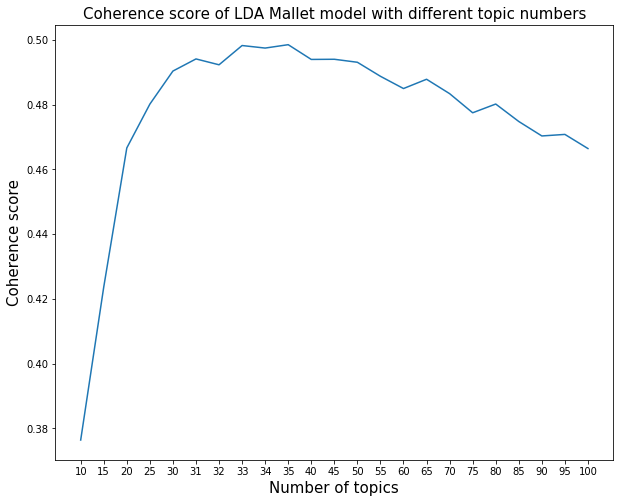

In [9]:
x = list(topicNum_score_dict.keys())
y = list(topicNum_score_dict.values())
plt.figure(figsize=(10,8))
plt.plot(x,y)
plt.ylabel("Coherence score",fontsize=15)
plt.xlabel("Number of topics",fontsize=15)
plt.title('Coherence score of LDA Mallet model with different topic numbers',fontsize=15)
plt.savefig('data/output/lda-mallet-tuning.png')
plt.show()

## Final Model and Output ##

In [6]:
# topic num is 35
ldamallet_tuned = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus,
                                                 id2word=id2word,
                                                 optimize_interval=20,
                                                  num_topics=35)

D:\Software\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [19]:
docTopicMatrix = pd.DataFrame(columns=range(0,35))
for row in ldamallet_tuned.load_document_topics():
    row_data = [x[1] for x in row]
    docTopicMatrix = docTopicMatrix.append(pd.DataFrame([row_data],columns=docTopicMatrix.columns))
docTopicMatrix = docTopicMatrix.reset_index(drop=True)
docTopicMatrix.shape, docTopicMatrix.head()

((2435, 35),
          0         1         2         3         4         5         6   \
 0  0.001198  0.017852  0.007894  0.014639  0.041404  0.054975  0.000146   
 1  0.010592  0.000108  0.000160  0.010744  0.024355  0.106979  0.001693   
 2  0.000077  0.000071  0.000106  0.001162  0.045579  0.049733  0.173478   
 3  0.000067  0.001755  0.009411  0.104364  0.003623  0.142755  0.000111   
 4  0.000087  0.000080  0.001230  0.354528  0.008082  0.013877  0.057905   
 
          7         8         9   ...        25        26        27        28  \
 0  0.184507  0.000118  0.000156  ...  0.000172  0.031171  0.000179  0.000083   
 1  0.000166  0.173734  0.073531  ...  0.000231  0.013562  0.010715  0.000111   
 2  0.000109  0.001089  0.041506  ...  0.012956  0.000062  0.000158  0.000073   
 3  0.011956  0.106843  0.061121  ...  0.005214  0.000054  0.000136  0.000063   
 4  0.036778  0.000118  0.006821  ...  0.000172  0.000070  0.063491  0.000083   
 
          29        30        31        3

In [20]:
topicWordMatrix = pd.DataFrame()
for idx, topic_string in ldamallet_tuned.show_topics(35):
    string_parts = [x.strip().split("*") for x in topic_string.split("+")]
    string_parts = [(float(x[0]),x[1][1:-1]) for x in string_parts]
    topicWordMatrix[idx] = string_parts
topicWordMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,"(0.032, war)","(0.127, woman)","(0.029, patient)","(0.017, country)","(0.012, kind)","(0.03, work)","(0.029, datum)","(0.061, school)","(0.033, water)","(0.029, money)",...,"(0.032, feel)","(0.095, brain)","(0.02, science)","(0.025, planet)","(0.033, ocean)","(0.06, city)","(0.025, art)","(0.023, government)","(0.052, cell)","(0.042, world)"
1,"(0.013, kill)","(0.058, man)","(0.025, cancer)","(0.016, world)","(0.01, structure)","(0.019, time)","(0.021, information)","(0.054, kid)","(0.029, energy)","(0.028, company)",...,"(0.028, people)","(0.015, neuron)","(0.016, people)","(0.025, universe)","(0.026, fish)","(0.032, building)","(0.024, image)","(0.018, country)","(0.02, dna)","(0.039, people)"
2,"(0.012, conflict)","(0.035, girl)","(0.023, disease)","(0.015, change)","(0.01, form)","(0.018, people)","(0.02, internet)","(0.038, student)","(0.014, oil)","(0.023, business)",...,"(0.021, experience)","(0.011, memory)","(0.015, question)","(0.017, space)","(0.021, water)","(0.022, design)","(0.019, work)","(0.016, power)","(0.017, gene)","(0.037, country)"
3,"(0.012, refugee)","(0.02, sex)","(0.02, health)","(0.011, China)","(0.009, system)","(0.012, change)","(0.015, people)","(0.031, child)","(0.012, carbon)","(0.017, market)",...,"(0.021, life)","(0.009, consciousness)","(0.012, study)","(0.016, star)","(0.019, sea)","(0.022, build)","(0.014, create)","(0.014, political)","(0.014, body)","(0.017, India)"
4,"(0.011, military)","(0.014, boy)","(0.017, doctor)","(0.01, growth)","(0.009, pattern)","(0.009, problem)","(0.013, phone)","(0.03, teacher)","(0.011, climate)","(0.014, pay)",...,"(0.018, love)","(0.009, sleep)","(0.011, answer)","(0.014, light)","(0.013, coral)","(0.018, place)","(0.014, light)","(0.013, democracy)","(0.013, life)","(0.014, child)"


In [10]:
# get the top 3 propabable topics of a talk
docTop3TopicMatrix = pd.DataFrame(list(docTopicMatrix.apply(lambda s: s.abs().nlargest(3).index.tolist(), axis=1)))

In [11]:
topicWordMatrix.to_csv('data/output/topicWordMatrix.csv',index=False)
docTopicMatrix.to_csv('data/output/docTopicMatrix.csv',index=False)
docTop3TopicMatrix.to_csv('data/output/docTop3TopicMatrix.csv',index=False)

In [12]:
pickle.dump(id2word,open('data/pickle/gensim_id2words.p','wb'))

In [13]:
pickle.dump(ldamallet_tuned,open('model/ldamallet_tuned.p','wb'))

In [15]:
# generate top topic distribution graph
topic_docCount_dict = {i:0 for i in range(35)}

for (t1,t2,t3) in docTop3TopicMatrix.to_numpy():
    topic_docCount_dict[t1] += 1    

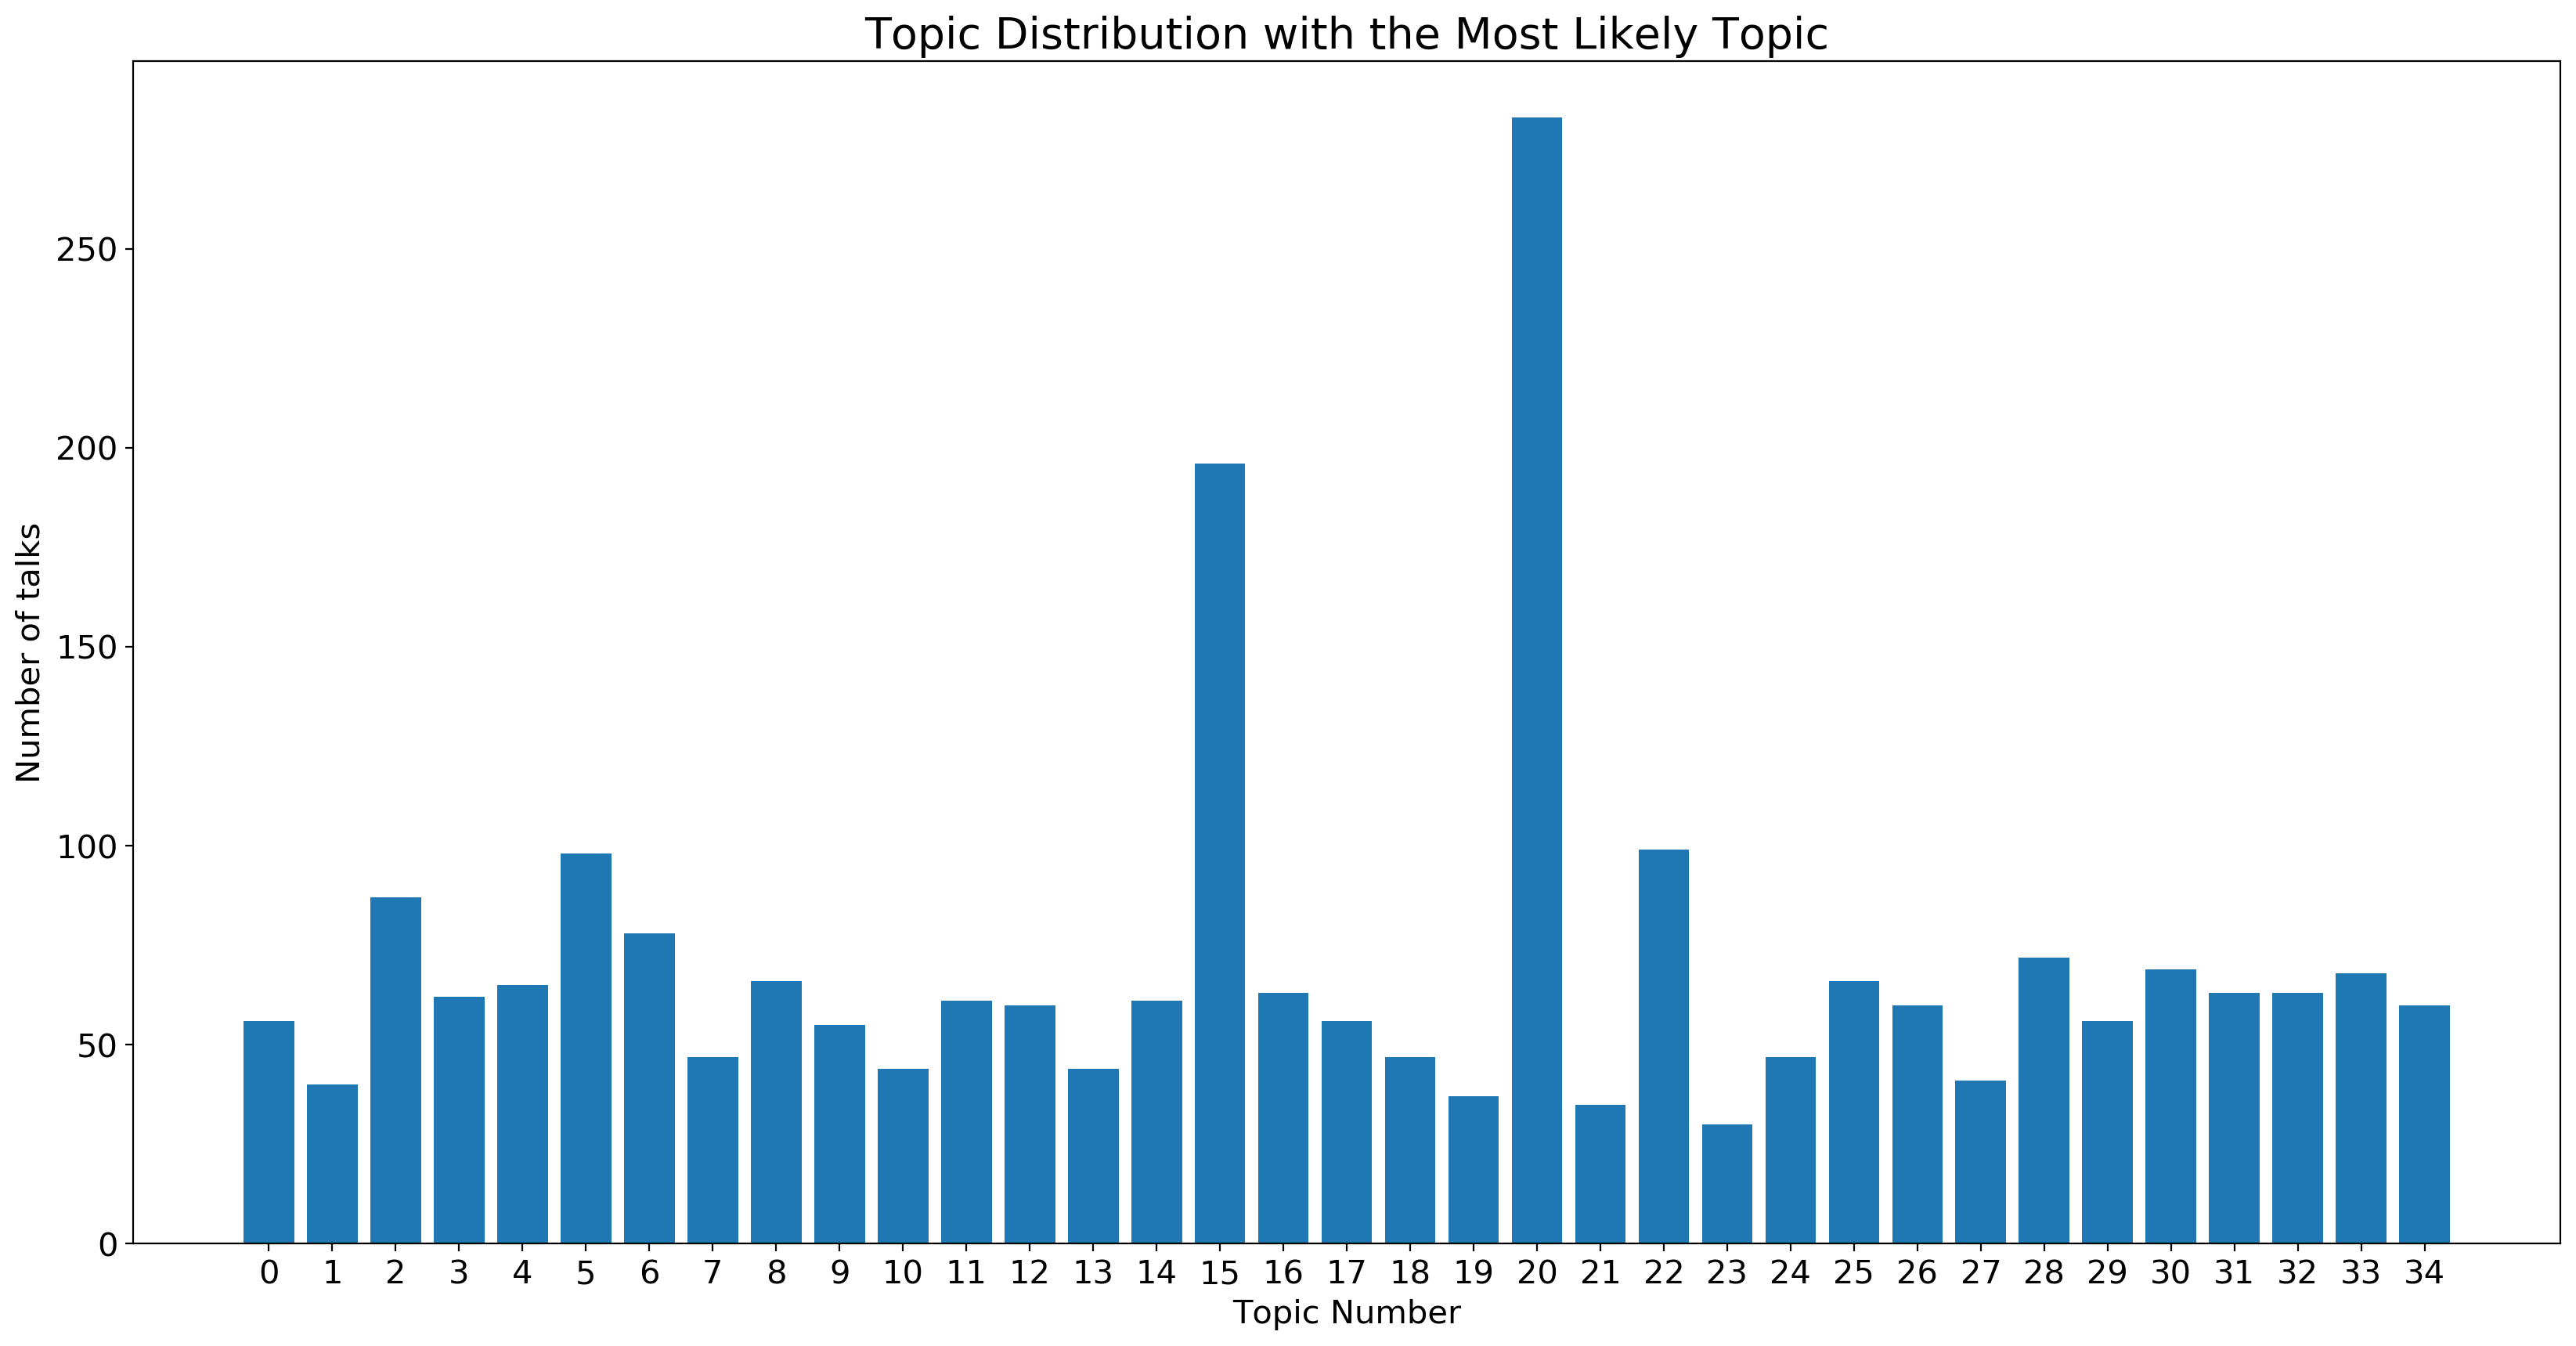

In [17]:
plt.figure(figsize=(20,10),dpi=200)
plt.bar(x=topic_docCount_dict.keys(),height=topic_docCount_dict.values())
plt.xticks(ticks=np.arange(35),fontsize=15)
plt.yticks(fontsize=15)
plt.title('Topic Distribution with the Most Likely Topic',fontsize=20)
plt.ylabel("Number of talks",fontsize=15)
plt.xlabel("Topic Number",fontsize=15)
plt.savefig("data/output/topTopicDistribution.png")
plt.show()